<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Модель" data-toc-modified-id="Модель-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Модель</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Восстановление золота из руды

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используйте данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import cross_val_score, GridSearchCV
from tqdm.notebook import tqdm

## Подготовка данных

На данном этапе выполняются следующие действия:
* Откройте файлы и изучите их.
* Проверьте, что эффективность обогащения рассчитана правильно. Вычислите её на обучающей выборке для признака rougher.output.recovery. Найдите MAE между вашими расчётами и значением признака. Опишите выводы.
* Проанализируйте признаки, недоступные в тестовой выборке. Что это за параметры? К какому типу относятся?
* Проведите предобработку данных.

Описание данных

Технологический процесс

- Rougher feed — исходное сырье
- Rougher additions (или reagent additions) — флотационные реагенты: (Xanthate, Sulphate, Depressant)
- Xanthate **— ксантогенат (промотер, или активатор флотации);
- Sulphate — сульфат (на данном производстве сульфид натрия);
- Depressant — депрессант (силикат натрия).
- Rougher process (англ. «грубый процесс») — флотация
- Rougher tails — отвальные хвосты
- Float banks — флотационная установка
- Cleaner process — очистка
- Rougher Au — черновой концентрат золота
- Final Au — финальный концентрат золота

Параметры этапов

- air amount — объём воздуха
- fluid levels — уровень жидкости
- feed size — размер гранул сырья
- feed rate — скорость подачи

Наименование признаков

Наименование признаков должно быть такое:<br>

[этап].[тип_параметра].[название_параметра]<br>
Пример: rougher.input.feed_ag<br>

Возможные значения для блока [этап]:<br>
- rougher — флотация
- primary_cleaner — первичная очистка
- secondary_cleaner — вторичная очистка
- final — финальные характеристики

Возможные значения для блока [тип_параметра]:
- input — параметры сырья
- output — параметры продукта
- state — параметры, характеризующие текущее состояние этапа
- calculation — расчётные характеристики

**Откройте файлы и изучите их**

In [2]:
train = pd.read_csv('/datasets/gold_recovery_train_new.csv')
test = pd.read_csv('/datasets/gold_recovery_test_new.csv')
full = pd.read_csv('/datasets/gold_recovery_full_new.csv')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
date                                                  14149 non-null object
final.output.concentrate_ag                           14148 non-null float64
final.output.concentrate_pb                           14148 non-null float64
final.output.concentrate_sol                          13938 non-null float64
final.output.concentrate_au                           14149 non-null float64
final.output.recovery                                 14149 non-null float64
final.output.tail_ag                                  14149 non-null float64
final.output.tail_pb                                  14049 non-null float64
final.output.tail_sol                                 14144 non-null float64
final.output.tail_au                                  14149 non-null float64
primary_cleaner.input.sulfate                         14129 non-null float64
primary_cleaner.input.depressant             

In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
date                                          5290 non-null object
primary_cleaner.input.sulfate                 5286 non-null float64
primary_cleaner.input.depressant              5285 non-null float64
primary_cleaner.input.feed_size               5290 non-null float64
primary_cleaner.input.xanthate                5286 non-null float64
primary_cleaner.state.floatbank8_a_air        5290 non-null float64
primary_cleaner.state.floatbank8_a_level      5290 non-null float64
primary_cleaner.state.floatbank8_b_air        5290 non-null float64
primary_cleaner.state.floatbank8_b_level      5290 non-null float64
primary_cleaner.state.floatbank8_c_air        5290 non-null float64
primary_cleaner.state.floatbank8_c_level      5290 non-null float64
primary_cleaner.state.floatbank8_d_air        5290 non-null float64
primary_cleaner.state.floatbank8_d_level      5290 non-null float64
rougher.in

In [5]:
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
date                                                  19439 non-null object
final.output.concentrate_ag                           19438 non-null float64
final.output.concentrate_pb                           19438 non-null float64
final.output.concentrate_sol                          19228 non-null float64
final.output.concentrate_au                           19439 non-null float64
final.output.recovery                                 19439 non-null float64
final.output.tail_ag                                  19438 non-null float64
final.output.tail_pb                                  19338 non-null float64
final.output.tail_sol                                 19433 non-null float64
final.output.tail_au                                  19439 non-null float64
primary_cleaner.input.sulfate                         19415 non-null float64
primary_cleaner.input.depressant             

In [6]:
full.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


Вывод: Данные загружены, в обучающей выборке 14149 объектов. В тестовой выборке 5290 обектов - достаточное количество для проведения исследования. В выборках присутствуют null значения, которые необходимо заполнить.

**Проверьте, что эффективность обогащения рассчитана правильно. Вычислите её на обучающей выборке для признака rougher.output.recovery. Найдите MAE между вашими расчётами и значением признака. Опишите выводы.**

In [7]:
train['rougher.calculation.recovery'] = (
   100 * (train['rougher.output.concentrate_au'] * (train['rougher.input.feed_au'] - train['rougher.output.tail_au'])) /
    (train['rougher.input.feed_au']*(train['rougher.output.concentrate_au'] - train['rougher.output.tail_au']))
)

In [8]:
mean_absolute_error(train['rougher.output.recovery'], train['rougher.calculation.recovery'])

1.1100347049376097e-14

Вывод: близкая к нулю ошибка показывает что эффективность обогащения rougher.output.recovery рассчитана правильно. 

**Проанализируйте признаки, недоступные в тестовой выборке. Что это за параметры? К какому типу относятся?**

In [9]:
features_missing_list = [x for x in train.columns if x not in test.columns]

In [10]:
features_missing_list

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.ta

Вывод: В тестовой выборке не доступны выходные параметры, которые измеряются после каждого технологического процесса очистки: концентрация полезных металлов и «отвальные хвосты», то есть остатки продукта с низкой концентрацией ценных металлов, а также расчитанные на их базе параметры. Очевидно что  "production" модели будут недоступны данные измерения на этапе предсказания, и она должна быть обучена без этих признаков. Также отсутствуют целевые признаки final.output.recovery и rougher.output.recovery.

**Проведите предобработку данных.**
На данном этапе избавимся от null значений в выборках:

In [11]:
test.isna().sum()[test.isna().sum()>0]

primary_cleaner.input.sulfate                4
primary_cleaner.input.depressant             5
primary_cleaner.input.xanthate               4
rougher.input.feed_rate                      3
rougher.input.feed_size                      1
rougher.input.feed_sol                      21
rougher.input.floatbank10_sulfate            5
rougher.input.floatbank11_sulfate            8
rougher.input.floatbank11_xanthate          25
secondary_cleaner.state.floatbank2_a_air     3
secondary_cleaner.state.floatbank2_b_air     2
secondary_cleaner.state.floatbank3_a_air     9
dtype: int64

In [12]:
train.isna().sum()[train.isna().sum()>0]

final.output.concentrate_ag                     1
final.output.concentrate_pb                     1
final.output.concentrate_sol                  211
final.output.tail_pb                          100
final.output.tail_sol                           5
                                             ... 
secondary_cleaner.state.floatbank5_a_level      1
secondary_cleaner.state.floatbank5_b_air        1
secondary_cleaner.state.floatbank5_b_level      1
secondary_cleaner.state.floatbank6_a_air        2
secondary_cleaner.state.floatbank6_a_level      1
Length: 62, dtype: int64

Для замены нулей в тестовой выборке, проверим наличие нулей в  полной выборке для соответствующих столбцов. Если в полной выборке значения отличаются, возмем их для замены нулей в тестовой выборке, если значения идентичны, заменим нули в тестовой выборке средними значениями параметра из полной выборки.

In [13]:
full.query('date in @test.date')[test.columns].isna().sum()[full.query('date in @test.date')[test.columns].isna().sum()>0]

primary_cleaner.input.sulfate                4
primary_cleaner.input.depressant             5
primary_cleaner.input.xanthate               4
rougher.input.feed_rate                      3
rougher.input.feed_size                      1
rougher.input.feed_sol                      21
rougher.input.floatbank10_sulfate            5
rougher.input.floatbank11_sulfate            8
rougher.input.floatbank11_xanthate          25
secondary_cleaner.state.floatbank2_a_air     3
secondary_cleaner.state.floatbank2_b_air     2
secondary_cleaner.state.floatbank3_a_air     9
dtype: int64

Значения нулей в тестовой и полной выборках совпадают, следовательно нули образовались до этапа разделения полной выборки на тестовую и обучающую. Заменим нулевые значения в тестовой и обучающей выборках средним по признаку полной выборки:

In [14]:
samples = [test, train]
for sample in samples:
    columns = sample.isna().sum()[sample.isna().sum()>0].index
    for column in columns:
        sample[column] = sample[column].fillna(full[column].mean())

In [15]:
test.isna().sum()[test.isna().sum()>0]

Series([], dtype: int64)

In [16]:
train.isna().sum()[train.isna().sum()>0]

Series([], dtype: int64)

Вывод: Нулевые значения заменены средними по признаку.

**Вывод по этапу 1**

Данные подготовлены для дальнейшего анализа и построения модели. Эффективность обогащения rougher.output.recovery рассчитана правильно. Обучать модель можно только на тех признаках, которые есть в тестовой выборке, так как только они будут доступны в рабочей модели. 

## Анализ данных

На данном этапе выполняем следующие исследования: 

2.1. Посмотрите, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Опишите выводы.<br>
2.2. Сравните распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.<br>
2.3. Исследуйте суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.<br>

**Посмотрите, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Опишите выводы.**

<function matplotlib.pyplot.show(*args, **kw)>

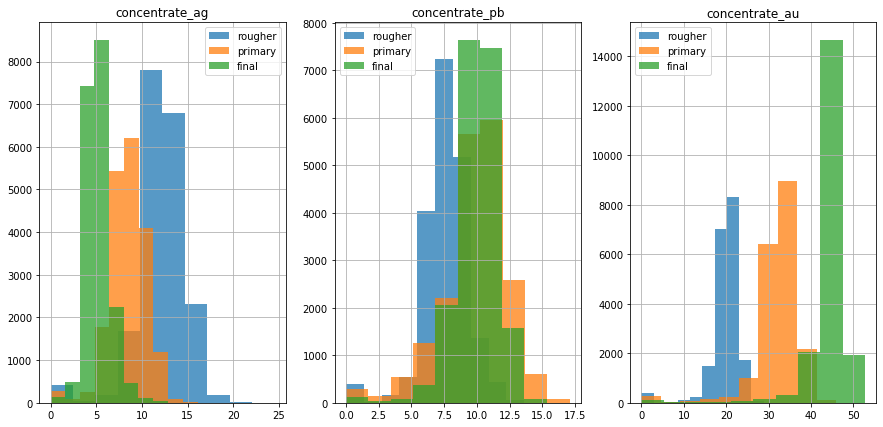

In [17]:
fig = plt.figure()
ax_1 = fig.add_subplot(1, 3, 1)
full['rougher.output.concentrate_ag'].hist(alpha=0.75)
full['primary_cleaner.output.concentrate_ag'].hist(alpha=0.75)
full['final.output.concentrate_ag'].hist(alpha=0.75)
ax_2 = fig.add_subplot(1, 3, 2)
full['rougher.output.concentrate_pb'].hist(alpha=0.75)
full['primary_cleaner.output.concentrate_pb'].hist(alpha=0.75)
full['final.output.concentrate_pb'].hist(alpha=0.75)
ax_3 = fig.add_subplot(1, 3, 3)
full['rougher.output.concentrate_au'].hist(alpha=0.75)
full['primary_cleaner.output.concentrate_au'].hist(alpha=0.75)
full['final.output.concentrate_au'].hist(alpha=0.75)        
ax_1.set_title('concentrate_ag')
ax_1.legend(['rougher', 'primary', 'final'])
ax_2.set_title('concentrate_pb')
ax_2.legend(['rougher', 'primary', 'final'])
ax_3.set_title('concentrate_au')
ax_3.legend(['rougher', 'primary', 'final'])
fig.set_figwidth(15)
fig.set_figheight(7)
plt.show

In [18]:
full[['rougher.output.concentrate_ag', 'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag']].mean()

rougher.output.concentrate_ag            11.994759
primary_cleaner.output.concentrate_ag     8.442408
final.output.concentrate_ag               5.168470
dtype: float64

In [19]:
full[['rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb']].mean()

rougher.output.concentrate_pb            7.606272
primary_cleaner.output.concentrate_pb    9.829530
final.output.concentrate_pb              9.978895
dtype: float64

In [20]:
full[['rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au']].mean()

rougher.output.concentrate_au            19.772000
primary_cleaner.output.concentrate_au    32.119400
final.output.concentrate_au              44.076513
dtype: float64

Вывод: На различных этапах очистки концентрация меняется следующим образом:
- au: на этапе флотации среднее значение 19.8, на этапе первой очистки - 32.1, на этапе второй очистки - 44.1
- ag: на этапе флотации среднее значение 12, на этапе первой очистки - 8.4, на этапе второй очистки - 5.2
- pb: на этапе флотации среднее значение 7.6, на этапе первой очистки - 9.8, на этапе второй очистки - 9.9

Наблюдаем что по мере прохождения этапов очистки концентрация золота растет, концентрация серебра уменьшается, а концентрация свинца - уменьшается на этапе флотации и дальше не меняется. 



**Сравните распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.**

<function matplotlib.pyplot.show(*args, **kw)>

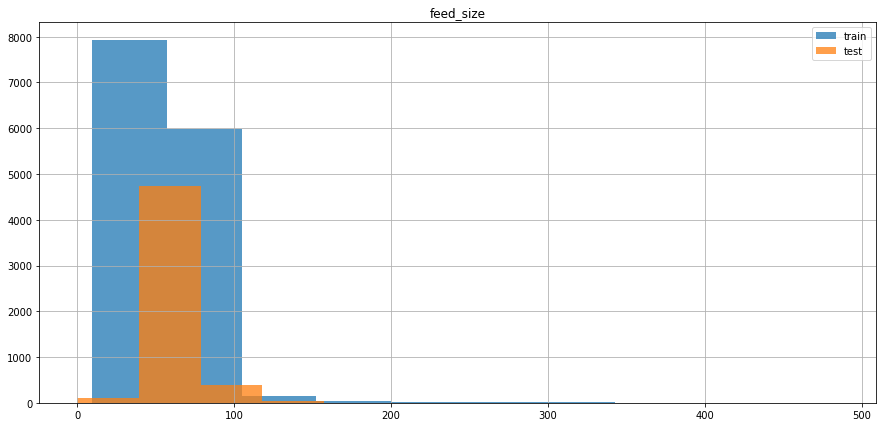

In [21]:
fig = plt.figure()
ax_1 = fig.add_subplot()

train['rougher.input.feed_size'].hist(alpha=0.75)
test['rougher.input.feed_size'].hist(alpha=0.75)
       
ax_1.set_title('feed_size')
ax_1.legend(['train', 'test'])

fig.set_figwidth(15)
fig.set_figheight(7)
plt.show

Вывод:  Распределения размеров гранул сырья на обучающей и тестовой выборках сопоставимы, адекватная оценка модели возможна

**Исследуйте суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.**

In [22]:
full['rougher.input.concentrate_all'] = (full['rougher.input.feed_ag'] + full['rougher.input.feed_au']
                                         + full['rougher.input.feed_pb'] + full['rougher.input.feed_sol'])

full['rougher.output.concentrate_all'] = (full['rougher.output.concentrate_ag'] + full['rougher.output.concentrate_au']
                                          + full['rougher.output.concentrate_pb'] + full['rougher.output.concentrate_sol'])

full['primary_cleaner.output.concentrate_all'] = (full['primary_cleaner.output.concentrate_ag'] + full['primary_cleaner.output.concentrate_au']
                                          + full['primary_cleaner.output.concentrate_pb'] + full['primary_cleaner.output.concentrate_sol'])

full['final.output.concentrate_all'] = (full['final.output.concentrate_ag'] + full['final.output.concentrate_au']
                                          + full['final.output.concentrate_pb'] + full['final.output.concentrate_sol'])

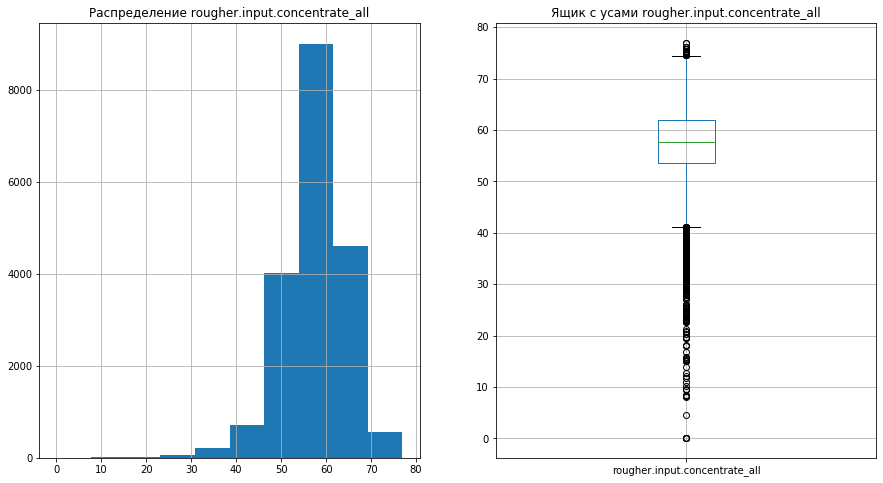

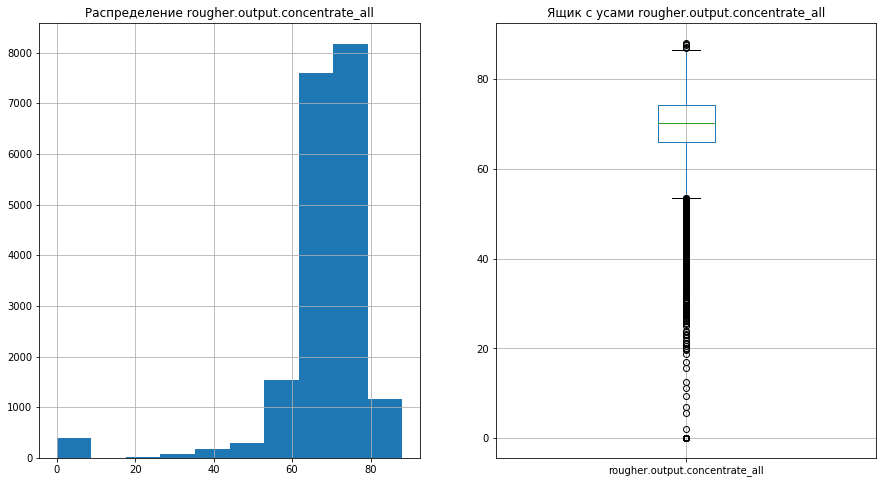

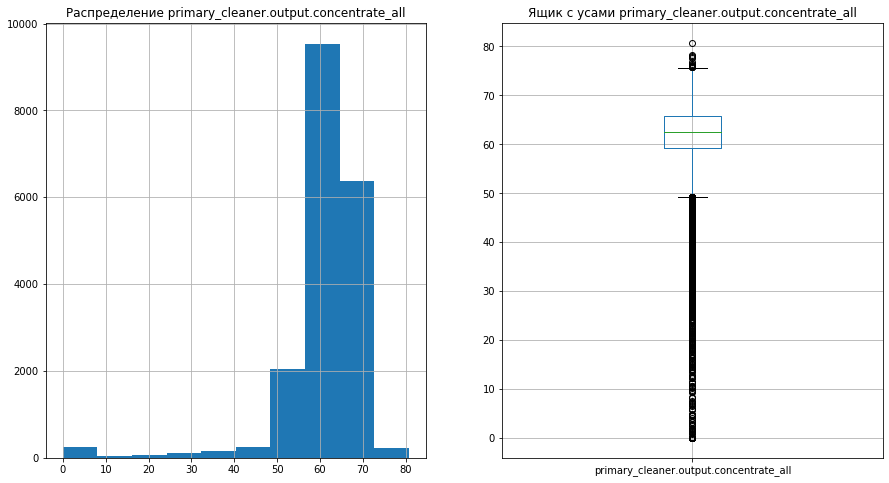

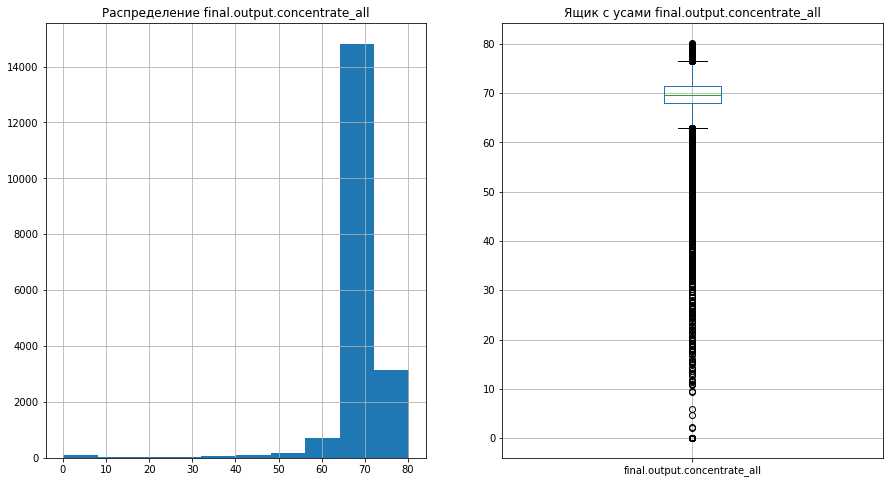

In [23]:
columns = (['rougher.input.concentrate_all', 'rougher.output.concentrate_all', 
            'primary_cleaner.output.concentrate_all', 'final.output.concentrate_all'])
for column in columns:
    fig = plt.figure()
    ax_1 = fig.add_subplot(1, 2, 1)
    full[column].hist()
    ax_2 = fig.add_subplot(1, 2, 2)
    full.boxplot(column=column)
    ax_1.set_title(f'Распределение {column}')
    ax_2.set_title(f'Ящик с усами {column}')
    fig.set_figwidth(15)
    fig.set_figheight(8)
    plt.show

Вывод: в данных присутстуют аномальные значения. Суммарная концентрация всех перечисленных веществ не может равняться нули ни на каком из этапов. Не могли же все эти вещества исчезнуть. Значит измерения с нулевой суммарной концентрацией - это какие-то сбои в сборе данных. То есть это мусор. Необходимо удалить такие данные из тестовой и обучающей выборки.

In [24]:
garbage = (full[(full['rougher.input.concentrate_all'] == 0) | (full['rougher.output.concentrate_all'] == 0) | 
               (full['primary_cleaner.output.concentrate_all']== 0) | (full['final.output.concentrate_all'] == 0)])

In [25]:
train = train.drop(train.query('date in @garbage.date').index.values) 

In [26]:
test = test.drop(test.query('date in @garbage.date').index.values)

**Вывод по этапу 2**
1. Наблюдаем что по мере прохождения этапов очистки концентрация золота растет, концентрация серебра уменьшается, а концентрация свинца - уменьшается на этапе флотации и дальше не меняется.
2. Распределения размеров гранул сырья на обучающей и тестовой выборках сопоставимы, адекватная оценка модели возможна
3. В данных присутстовали аномальные значения. Суммарная концентрация всех перечисленных веществ не может равняться нули ни на каком из этапов. Такие объекты были удалены из тестовой и обучающей выборках.

## Модель

На данном этапе выполняются следующие шаги:
- 3.1. Напишите функцию для вычисления итоговой sMAPE.
- 3.2. Обучите разные модели и оцените их качество кросс-валидацией. Выберите лучшую модель и проверьте её на тестовой выборке. Опишите выводы.

**Напишите функцию для вычисления итоговой sMAPE.**

In [27]:
def smape_count_full(taget_rouger, probabilities_rouger,taget_final, probabilities_final):
    smape_rouger = np.mean(100*abs(taget_rouger - probabilities_rouger)/((abs(taget_rouger) + abs(probabilities_rouger))/2))
    smape_final = np.mean(100*abs(taget_final - probabilities_final)/((abs(taget_final) + abs(probabilities_final))/2))
    return 0.25*smape_rouger + 0.75*smape_final

In [28]:
def smape_count(taget, probabilities):
    return np.mean(100*abs(taget - probabilities)/((abs(taget) + abs(probabilities))/2))

In [29]:
smap_score = make_scorer(smape_count, greater_is_better=False)

**Обучите разные модели и оцените их качество кросс-валидацией. Выберите лучшую модель и проверьте её на тестовой выборке. Опишите выводы.**

Для обучения модели а этапе предсказания rougher, необходимо использовать признаки относящиеся к этому этапу. На этапе final будем использовать все признаки. 

In [30]:
features_final_train = train[test.columns].drop(columns='date')
target_rougher_train = train['rougher.output.recovery']
target_final_train = train['final.output.recovery']
features_rougher_train = features_final_train[[x for x in features_final_train.columns if 'rougher' in x]]

Для оценки аекватности модели найдем значение метрики sMAPE для DummyRegressor

In [31]:
dummy = DummyRegressor(strategy="mean")
predict_rougher = dummy.fit(features_rougher_train, target_rougher_train).predict(features_rougher_train)
predict_final = dummy.fit(features_final_train, target_final_train).predict(features_final_train)

In [32]:
smape_count_full (target_rougher_train, predict_rougher, target_final_train, predict_final)

9.486609457738226

Подбор лучших параметров для моделей DecisionTreeRegressor

In [33]:
(GridSearchCV(estimator=DecisionTreeRegressor(), param_grid={'max_depth': [1, 5, 10, 15, 20, 25, 30]},scoring=smap_score)
 .fit(features_rougher_train, target_rougher_train).best_params_)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'max_depth': 5}

In [34]:
(GridSearchCV(estimator=DecisionTreeRegressor(), param_grid={'max_depth': [1, 5, 10, 15, 20, 25, 30]},scoring=smap_score)
 .fit(features_final_train, target_final_train).best_params_)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'max_depth': 1}

- Для модели DecisionTreeRegressor предсказывающей sMAPE на этапе флотации - наилучший параметр max_depth = 5
- Для модели DecisionTreeRegressor предсказывающей sMAPE на этапе финальной очистки - наилучший параметр max_depth = 1

Подбор лучших параметров для моделей RandomForestRegressor

In [35]:
(GridSearchCV(estimator=RandomForestRegressor(), param_grid={'max_depth': [1, 5, 10], 'n_estimators':[100, 200, 300]}
              ,scoring=smap_score).fit(features_rougher_train, target_rougher_train).best_params_)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'max_depth': 5, 'n_estimators': 100}

In [36]:
(GridSearchCV(estimator=RandomForestRegressor(), param_grid={'max_depth': [1, 5, 10], 'n_estimators':[100, 200, 300]}
              ,scoring=smap_score).fit(features_final_train, target_final_train).best_params_)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'max_depth': 1, 'n_estimators': 100}

- Для модели RandomForestRegressor() предсказывающей sMAPE на этапе флотации - наилучшие параметры max_depth = 5, n_estimators = 100
- Для модели RandomForestRegressor() предсказывающей sMAPE на этапе финальной очистки - наилучшие параметры max_depth = 1, n_estimators = 100

In [37]:
models = [LinearRegression(), DecisionTreeRegressor(max_depth=5), RandomForestRegressor(n_estimators=100, max_depth=5)]
for model in models:
    smape_rouger = -1*cross_val_score(model, features_rougher_train, target_rougher_train, cv=5, scoring=smap_score)
    smape_final = -1*cross_val_score(model, features_final_train, target_final_train, cv=5, scoring=smap_score)
    print(model)
    print(f'sMAPE этап Флотации: {np.mean(smape_rouger)}')
    print(f'sMAPE этап Финальной очистки: {np.mean(smape_final)}')
    print(f'Итоговый sMAPE {np.mean(0.25*smape_rouger + 0.75*smape_final)}')
    print()

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
sMAPE этап Флотации: 6.685192436426763
sMAPE этап Финальной очистки: 11.211911023172869
Итоговый sMAPE 10.080231376486342

DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')
sMAPE этап Флотации: 7.994771923784766
sMAPE этап Финальной очистки: 9.929769782920664
Итоговый sMAPE 9.44602031813669

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=200,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, 

Вывод по 3-му этапу:
1. Написана функция для вычисления итоговой sMAPE. Создан критерий оценки моделей smap_score
2. модель DummyRegressor, при формировании предсказаний стандартным значением mean показала результат sMAPE = 9.49. Необходимо подобрать наилучшую модель с параметром sMAPE ниже данного значения.
3. Рассмотрены 3 модели, показавшие следующие результаты:
- LinearRegression - sMAPE = 10.08
- DecisionTreeRegressor - sMAPE = 9.44
- RandomForestRegressor -  sMAPE = 10.5

Таким образом, наилучшей моделью для предсказания является DecisionTreeRegressor

**Вычислим  sMAPE для тестовой выборки:**

In [38]:
smap_score_final = make_scorer(smape_count_full, greater_is_better=False)

In [40]:
features_test = test.drop(columns='date')
target_test = full.query('date in @test.date')[['rougher.output.recovery','final.output.recovery']]

In [44]:
target_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5123 entries, 4682 to 15059
Data columns (total 2 columns):
rougher.output.recovery    5123 non-null float64
final.output.recovery      5123 non-null float64
dtypes: float64(2)
memory usage: 120.1 KB


In [43]:
DecisionTreeRegressor().fit(features_test,target_test).predict()

TypeError: predict() missing 1 required positional argument: 'X'

In [49]:
features_final_test = test.drop(columns='date')
target_final_test = full.query('date in @test.date')['final.output.recovery']
features_rougher_test = features_final_test[[x for x in features_final_train.columns if 'rougher' in x]]
target_rougher_test = full.query('date in @test.date')['rougher.output.recovery']

In [50]:
(GridSearchCV(estimator=DecisionTreeRegressor(), param_grid={'max_depth': [1, 5, 10, 15, 20, 25, 30]},scoring=smap_score)
 .fit(features_rougher_test, target_rougher_test).best_params_)

{'max_depth': 5}

In [52]:
(GridSearchCV(estimator=DecisionTreeRegressor(), param_grid={'max_depth': [1, 5, 10, 15, 20, 25, 30]},scoring=smap_score)
 .fit(features_final_test, target_final_test).best_params_)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'max_depth': 1}

In [58]:
model_rougher = DecisionTreeRegressor(max_depth = 5)
model_final = DecisionTreeRegressor(max_depth = 1)

smape_rouger = -1*cross_val_score(model_rougher, features_rougher_test, target_rougher_test, cv=5, scoring=smap_score)
smape_final = -1*cross_val_score(model_final, features_final_test, target_final_test, cv=5, scoring=smap_score)

print(f'sMAPE этап Флотации: {np.mean(smape_rouger)}')
print(f'sMAPE этап Финальной очистки: {np.mean(smape_final)}')
print(f'Итоговый sMAPE {np.mean(0.25*smape_rouger + 0.75*smape_final)}')


sMAPE этап Флотации: 4.9388507721976875
sMAPE этап Финальной очистки: 7.730284260910492
Итоговый sMAPE 7.0324258887322895


In [59]:
model_rougher = LinearRegression()
model_final = LinearRegression()

smape_rouger = -1*cross_val_score(model_rougher, features_rougher_test, target_rougher_test, cv=5, scoring=smap_score)
smape_final = -1*cross_val_score(model_final, features_final_test, target_final_test, cv=5, scoring=smap_score)

print(f'sMAPE этап Флотации: {np.mean(smape_rouger)}')
print(f'sMAPE этап Финальной очистки: {np.mean(smape_final)}')
print(f'Итоговый sMAPE {np.mean(0.25*smape_rouger + 0.75*smape_final)}')


sMAPE этап Флотации: 4.672008944209935
sMAPE этап Финальной очистки: 8.636420937471062
Итоговый sMAPE 7.645317939155779


Сравним с 

In [54]:
dummy = DummyRegressor(strategy="mean")
predict_rougher = dummy.fit(features_rougher_test, target_rougher_test).predict(features_rougher_test)
predict_final = dummy.fit(features_final_test, target_final_test).predict(features_final_test)

In [56]:
smape_count_full (target_rougher_test, predict_rougher, target_final_test, predict_final)

6.849373526938927

smape_count_full (target_rougher_train, predict_rougher, target_final_train, predict_final)

**Общий вывод по проекту:**<br>
1. Для построения модели предсказания коэффициента восстановления золота из золотосодержащей руды были поучены выборки:
- обучающая (train)
- тестовая (test)
- полная (full)
После исследования данных были сделаны следующие выводы:
- Данные содержали пропуски, которые были заменены
- Колличество признаков в обучающей и тестовой выборке не совпадало. В обучающей выборке дополнительно присутствовали  выходные параметры, которые измеряются после каждого технологического процесса очистки: концентрация полезных металлов и «отвальные хвосты», то есть остатки продукта с низкой концентрацией ценных металлов, а также расчитанные на их базе параметры. Очевидно что "production" модели будут недоступны данные измерения на этапе предсказания, и она должна быть обучена без этих признаков.
- Данные содержали аномальные значения:  Суммарная концентрация всех перечисленных веществ не может равняться нули ни на каком из этапов. Такие данные были удалены.
2. Написана функция для вычисления итоговой sMAPE. Создан критерий оценки моделей smap_score. Модель DummyRegressor, при формировании предсказаний стандартным значением mean показала результат sMAPE = 9.49. Необходимо подобрать наилучшую модель с параметром sMAPE ниже данного значения.
3. Рассмотрены 3 модели, показавшие следующие результаты:
- LinearRegression - sMAPE = 10.08
- DecisionTreeRegressor - sMAPE = 9.44
- RandomForestRegressor -  sMAPE = 10.5
4. Наилучшая моделью DecisionTreeRegressor проверяна на тестовой выборке, результат sMAPE = 7.03, 

Таким образом, наилучшей моделью для предсказания является DecisionTreeRegressor: 
предсказать коэффициент восстановления золота из золотосодержащей руды.

## Чек-лист готовности проекта

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке выполнения
- [x]  Выполнен шаг 1: данные подготовлены
    - [x]  Проверена формула вычисления эффективности обогащения
    - [x]  Проанализированы признаки, недоступные в тестовой выборке
    - [x]  Проведена предобработка данных
- [x]  Выполнен шаг 2: данные проанализированы
    - [x]  Исследовано изменение концентрации элементов на каждом этапе
    - [x]  Проанализированы распределения размеров гранул на обучающей и тестовой выборках
    - [x]  Исследованы суммарные концентрации
- [x]  Выполнен шаг 3: построена модель прогнозирования
    - [x]  Написана функция для вычисления итогового *sMAPE*
    - [x]  Обучено и проверено несколько моделей
    - [x]  Выбрана лучшая модель, её качество проверено на тестовой выборке